## I am using LUNA16 competition dataset

Lung cancer is the leading cause of cancer-related death worldwide. Screening high risk individuals for lung cancer with low-dose CT scans is now being implemented in the United States and other countries are expected to follow soon. In CT lung cancer screening, many millions of CT scans will have to be analyzed, which is an enormous burden for radiologists. Therefore there is a lot of interest to develop computer algorithms to optimize screening.?

The upcoming high-profile?Coding4Cancer?challenge invites coders to create the best computer algorithm that can identify a person as having lung cancer based on one or multiple low-dose CT images.

To be able to solve the Coding4Cancer challenge, and detect lung cancer in an early stage, pulmonary nodules, the early manifestation of lung cancers, have to be located. Many Computer-aided detection (CAD) systems have already been proposed for this task. The LUNA16 challenge will focus on a large-scale evaluation of automatic nodule detection algorithms on the publicly available LIDC/IDRI dataset.

## Things to do!
### Monday
1. .mhd files (extract 3D image data) - done

### Tuesday
2. Extract 2D image slice based on the coordinates?
3. Preprocess data


### Day after + Thursday
4. Train a CNN
5. Validate using their evaluation
6. Uncertainty quantification



### Import necessary libraries

In [28]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import os
import glob

import SimpleITK as sitk

from PIL import Image

from scipy.misc import imread

%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

### Let us import annotations

In [2]:
annotations = pd.read_csv('../src/data/annotations.csv')
candidates = pd.read_csv('../src/data/candidates.csv')

In [3]:
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [4]:
candidates['class'].sum()

1351

In [5]:
len(annotations)

1186

### Candidates have two classes, one with nodules, one without

In [6]:
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551065 entries, 0 to 551064
Data columns (total 5 columns):
seriesuid    551065 non-null object
coordX       551065 non-null float64
coordY       551065 non-null float64
coordZ       551065 non-null float64
class        551065 non-null int64
dtypes: float64(3), int64(1), object(1)
memory usage: 21.0+ MB


In [7]:
print len(candidates[candidates['class'] == 1])
print len(candidates[candidates['class'] == 0])

1351
549714


In [8]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print num_cores

4


### Classes are heaviliy unbalanced, hardly 0.2% percent are positive.

The best way to move forward will be to undersample the negative class and then augment the positive class heaviliy to balance out the samples.

#### Plan of attack:

1. Get an initial subsample of negative class and keep all of the positives such that we have a 80/20 class distribution

2. Create a training set such that we augment minority class heavilby rotating to get a 50/50 class distribution

In [9]:
class CTScan(object):
    def __init__(self, filename = None, coords = None):
        self.filename = filename
        self.coords = coords
        self.ds = None
        self.image = None

    def reset_coords(self, coords):
        self.coords = coords

    def read_mhd_image(self):
        path = glob.glob('../data/raw/*/'+ self.filename + '.mhd')
        self.ds = sitk.ReadImage(path[0])
        self.image = sitk.GetArrayFromImage(self.ds)

    def get_resolution(self):
        return self.ds.GetSpacing()

    def get_origin(self):
        return self.ds.GetOrigin()

    def get_ds(self):
        return self.ds

    def get_voxel_coords(self):
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords)
    
    def get_image(self):
        return self.image
    
    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords()
        subImage = self.image[z, y-width/2:y+width/2, x-width/2:x+width/2]
        return subImage   
    
    def normalizePlanes(self, npzarray):
        maxHU = 400.
        minHU = -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
    
    def save_image(self, filename, width):
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)
        

In [10]:
positives = candidates[candidates['class']==1].index  
negatives = candidates[candidates['class']==0].index

###  Check if my class works

In [11]:
scan = CTScan(np.asarray(candidates.iloc[negatives[600]])[0], \
              np.asarray(candidates.iloc[negatives[600]])[1:-1])
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

### Try it on a test set you know works

In [13]:
filename = '1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208'
coords = (70.19, -140.93, 877.68)#[877.68, -140.93, 70.19]
scan = CTScan(filename, coords)
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

###  Ok the class to get image data works

Next thing to do is to undersample negative class drastically. Since the number of positives in the data set of 551065 are 1351 and rest are negatives, I plan to make the dataset less skewed. Like a 70%/30% split.

In [15]:
positives

Int64Index([    13,     78,   1303,   3050,   3052,   3080,   3223,   3285,
              3287,   3289,
            ...
            545928, 546205, 546372, 546400, 547498, 548674, 550171, 550334,
            550810, 550906],
           dtype='int64', length=1351)

In [16]:
np.random.seed(42)
negIndexes = np.random.choice(negatives, len(positives)*5, replace = False)

In [17]:
candidatesDf = candidates.iloc[list(positives)+list(negIndexes)]

### Now split it into test train set 

In [18]:
from sklearn.cross_validation import train_test_split
X = candidatesDf.iloc[:,:-1]
y = candidatesDf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

### Create a validation dataset

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

In [20]:
len(X_train)

5187

In [21]:
X_train.to_pickle('traindata')
X_test.to_pickle('testdata')
X_val.to_pickle('valdata')

In [22]:
def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

### Focus on training data

In [23]:
print 'number of positive cases are ' + str(y_train.sum())
print 'total set size is ' + str(len(y_train))
print 'percentage of positive cases are ' + str(y_train.sum()*1.0/len(y_train))

number of positive cases are 845
total set size is 5187
percentage of positive cases are 0.16290726817


### There are 845 positive cases out of 5187 cases in the training set. We will need to augment the positive dataset like mad. 

### Add new keys to X_train and y_train for augmented data

In [24]:
tempDf = X_train[y_train == 1]
tempDf = tempDf.set_index(X_train[y_train == 1].index + 1000000)
X_train_new = X_train.append(tempDf)
tempDf = tempDf.set_index(X_train[y_train == 1].index + 2000000)
X_train_new = X_train_new.append(tempDf)

ytemp = y_train.reindex(X_train[y_train == 1].index + 1000000)
ytemp.loc[:] = 1
y_train_new = y_train.append(ytemp)
ytemp = y_train.reindex(X_train[y_train == 1].index + 2000000)
ytemp.loc[:] = 1
y_train_new = y_train_new.append(ytemp)

print len(X_train_new), len(y_train_new)


6877 6877


In [35]:
X_train_new.index


Int64Index([  59270,  150277,  432208,  423122,  344581,   75111,  246217,
             292479,  147683,  468235,
            ...
            2282167, 2300642, 2021354, 2461166, 2332952, 2436163, 2013078,
            2352132, 2188812, 2459476],
           dtype='int64', length=6877)

### Preprocessing

In [26]:
from scipy.misc import imresize
from PIL import ImageEnhance

class PreProcessing(object):
    def __init__(self, image = None):
        self.image = image
    
    def subtract_mean(self):
        self.image = (self.image/255.0 - 0.25)*255
        return self.image
    
    def downsample_data(self):
        self.image = imresize(self.image, size = (40, 40), interp='bilinear', mode='L')
        return self.image
    
    def enhance_contrast(self):
        self.image = ImageEnhance.Contrast(self.image)
        return self.image
        

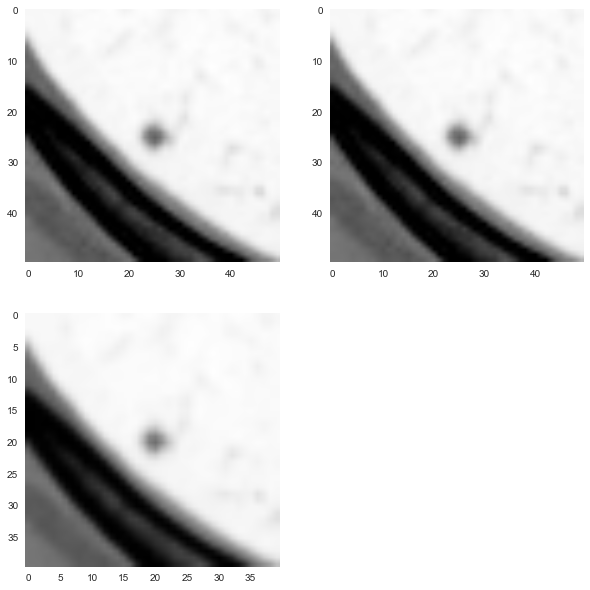

In [36]:
dirName = '../src/data/train/'
plt.figure(figsize = (10,10))
inp = imread(dirName + 'image_'+ str(30517) + '.jpg')
plt.subplot(221)
plt.imshow(inp)
plt.grid(False)

Pp = PreProcessing(inp)

inp2 = Pp.subtract_mean()
plt.subplot(222)
plt.imshow(inp2)
plt.grid(False)

#inp4 = Pp.enhance_contrast()
#plt.subplot(224)
#plt.imshow(inp4)
#plt.grid(False)

inp3 = Pp.downsample_data()
plt.subplot(223)
plt.imshow(inp3)
plt.grid(False)

#inp4 = Pp.enhance_contrast()
#plt.subplot(224)
#plt.imshow(inp4)
#plt.grid(False)

In [ ]:
dirName

### Convnet stuff

I am planning t  us tflearn which is a wrapper around tensorflow

In [37]:
import tflearn

### loading image data on the fly is inefficient. So I am us

In [38]:
y_train_new.values.astype(int)

array([0, 0, 0, ..., 1, 1, 1])

In [44]:
train_filenames =\
X_train_new.index.to_series().apply(lambda x:\
                                    '../src/data/train/image_'+str(x)+'.jpg')
train_filenames.values.astype(str)

array(['../src/data/train/image_59270.jpg',
       '../src/data/train/image_150277.jpg',
       '../src/data/train/image_432208.jpg', ...,
       '../src/data/train/image_2352132.jpg',
       '../src/data/train/image_2188812.jpg',
       '../src/data/train/image_2459476.jpg'], 
      dtype='|S35')

In [45]:
dataset_file = 'traindatalabels.txt'

train_filenames =\
X_train_new.index.to_series().apply(lambda x:\
   
filenames = train_filenames.values.astype(str)
labels = y_train_new.values.astype(int)
traindata = np.zeros(filenames.size,\
                     dtype=[('var1', 'S36'), ('var2', int)])
traindata['var1'] = filenames
traindata['var2'] = labels

np.savetxt(dataset_file, traindata, fmt="%10s %d")

In [48]:
# Build a HDF5 dataset (only required once)
from tflearn.data_utils import build_hdf5_image_dataset
build_hdf5_image_dataset(dataset_file, image_shape=(50, 50), mode='file', output_path='traindataset.h5', categorical_labels=True, normalize=True)


In [63]:
# Load HDF5 dataset
import h5py
h5f = h5py.File('traindataset.h5', 'r')
X_train_images = h5f['X']
Y_train_labels = h5f['Y']

h5f2 = h5py.File('../src/data/valdataset.h5', 'r')
X_val_images = h5f2['X']
Y_val_labels = h5f2['Y']

## loading tflearn packages

In [50]:
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

In [51]:
# Make sure the data is normalized
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

In [52]:
# Create extra synthetic training data by flipping, rotating and blurring the
# images on our data set.
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)
img_aug.add_random_blur(sigma_max=3.)

In [53]:
# Input is a 50x50 image with 1 color channels (grayscale)
network = input_data(shape=[None, 50, 50, 1],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)

In [54]:
# Step 1: Convolution
network = conv_2d(network, 50, 3, activation='relu')

In [55]:
# Step 2: Max pooling
network = max_pool_2d(network, 2)

In [56]:
# Step 3: Convolution again
network = conv_2d(network, 64, 3, activation='relu')

In [57]:
# Step 4: Convolution yet again
network = conv_2d(network, 64, 3, activation='relu')

In [58]:
# Step 5: Max pooling again
network = max_pool_2d(network, 2)

In [59]:
# Step 6: Fully-connected 512 node neural network
network = fully_connected(network, 512, activation='relu')

In [60]:
# Step 7: Dropout - throw away some data randomly during training to prevent over-fitting
network = dropout(network, 0.5)

In [61]:
# Step 8: Fully-connected neural network with two outputs (0=isn't a nodule, 1=is a nodule) to make the final prediction
network = fully_connected(network, 2, activation='softmax')

In [62]:
# Tell tflearn how we want to train the network
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)

In [65]:
# Wrap the network in a model object
model = tflearn.DNN(network, tensorboard_verbose=0, checkpoint_path='nodule-classifier.tfl.ckpt')

# Train it! We'll do 100 training passes and monitor it as it goes.
model.fit(X_train_images, Y_train_labels, n_epoch=100, shuffle=True, validation_set=(X_val_images, Y_val_labels),
          show_metric=True, batch_size=96,
          snapshot_epoch=True,
          run_id='nodule-classifier')

# Save model when training is complete to a file
model.save("nodule-classifier.tfl")
print("Network trained and saved as nodule-classifier.tfl!")

Training Step: 7199  | time: 100.337s
| Adam | epoch: 100 | loss: 0.00000 - acc: 0.9767 -- iter: 6816/6877
Training Step: 7200  | time: 108.674s
| Adam | epoch: 100 | loss: 0.00000 - acc: 0.9769 | val_loss: 0.26324 - val_acc: 0.9329 -- iter: 6877/6877
--
INFO:tensorflow:/Volumes/LittleOne/Insight/LungCancerProject/LungNoduleCNN/notebooks/nodule-classifier.tfl.ckpt-7200 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:/Volumes/LittleOne/Insight/LungCancerProject/LungNoduleCNN/notebooks/nodule-classifier.tfl is not in all_model_checkpoint_paths. Manually adding it.
Network trained and saved as nodule-classifier.tfl!


In [68]:
h5f2 = h5py.File('../src/data/testdataset.h5', 'r')
X_test_images = h5f2['X']
Y_test_labels = h5f2['Y']


In [69]:
model.predict(X_test_images)

IOError: Can't prepare for writing data (No write intent on file)